# Ablation Study
---
애블레이션 연구(ablation study) : 제거 연구

딥러닝 논문은 여러 가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시합니다.  
이때 제안한 방법들의 유효함을 증명하기 위해서  

보통 딥러닝 논문에서는 해당 방법을 "제거"한 모델로 수행한 실험  
해당 방법을 추가한 모델로 수행한 실험의 결과를 비교  

애블레이션 연구란 이처럼 "아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험  

이미지넷(ImageNet) 검증 데이터셋(validation dataset)에 대한 Top-1 error rate을 지표로 사용  
residual connection이 없는 일반 네트워크(plain net)와 ResNet을 비교  

이 비교를 통해서 ResNet이 residual connection을 활용해서 깊은 네트워크를 쌓았을 때, 이를 통한 성능 향상을 얻을 수 있음을 증명  

---
### CIFAR-10 데이터 셋 준비


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# 데이터 로드
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)
클래스 수: 10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


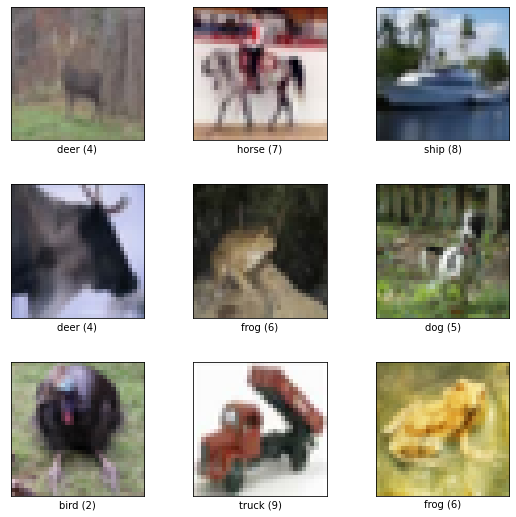

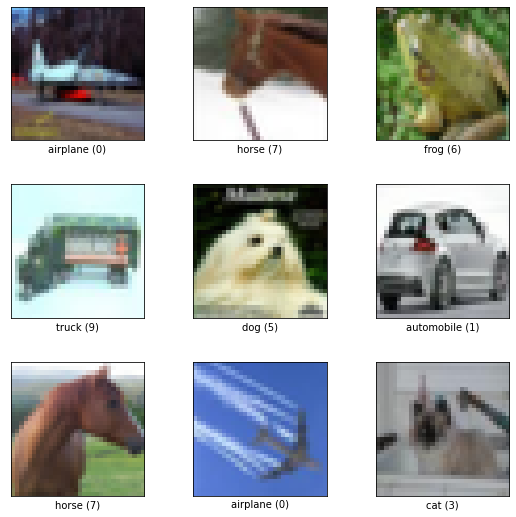

In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

# CIFAR-10 클래스
print('클래스 수:', ds_info.features["label"].num_classes)
print(ds_info.features["label"].names)

fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

### Input Normalization
데이터의 범위를 사용자가 원하는 범위로 제한하는 것  

이미지 데이터의 경우 픽셀 정보를 0 ~ 255 사이의 값으로 가지는데, 이를 255로 나누어주면 0~1.0 사이의 값  
(정규화하고자 하는 값 - 데이터 값들 중 최소값) / (데이터 값들 중 최대값 - 데이터 값들 중 최소값)  
 
Data Normalization을 하는 이유는  
머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지  
딥러닝에서 Local optimum에 빠질 위험 감소(학습 속도 향상)  

그리고 scikit-learn에서 MinMaxScaler로 쉽게 사용 가능  

우리는 "가로 1920, 세로 1080 픽셀의 이미지"처럼 픽셀의 수를 사용해 이미지의 크기를 말할 수 있는데요.  
이때 한 픽셀이 가진 채널(channel) 값은 픽셀의 색을 표현  
RGB는 Red, Green, Blue로 세 가지 색을 조합해서 우리가 보는 다양한 색을 만들어내는 방법   
그레이 스케일(gray scale)은 단순하게 흑과 백만을 표현하는 하나의 채널을 가진 이미지  
RGB나 그레이 스케일 외에도 HSV, CMYK 등 인쇄 또는 이미지 작업을 위해 사용되는 다양한 채널 체계가 있다.  

우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize) 를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어준다.  


In [4]:
# 이미지의 표현이 0과 1 사이로 들어오도록 정규화
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

#### 레이어(layer)
텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위  

#### 블록(block)
모델을 프로그램으로 구현하는 과정에서 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경하거나  
모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 필요  
이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위  

---
## VGG 기본 블럭 만들기
---
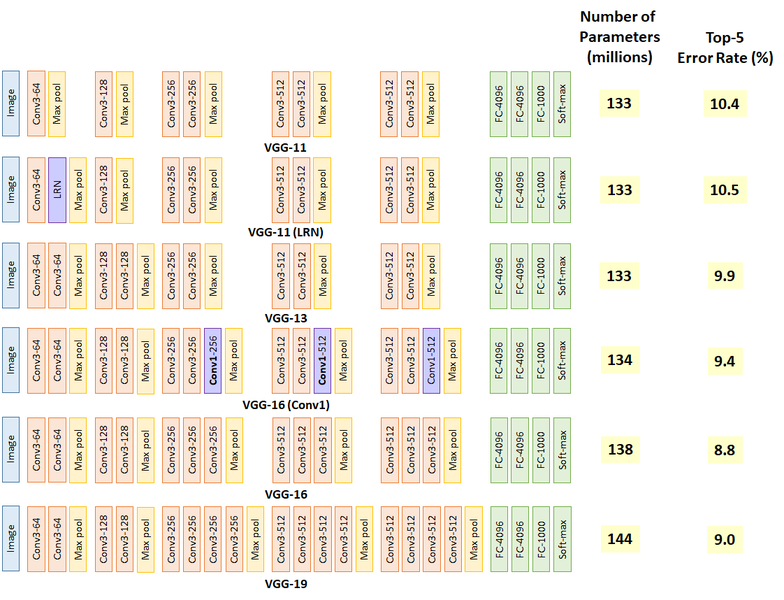  

VGG의 VGG-16과 VGG-19의 기본 구조가 되는 블록 구현  

모델 구조의 특징  
- VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 구성
- CNN은 모두 커널 크기가 3x3 라는 대표적인 특징
- 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있다.  
- 블록에 따라서 CNN 레이어의 개수 또한 달라진다. 블록의 마지막에는 항상 Max Pooling 레이어가 붙는다.  
 
따라서 우리의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 한다.  

block_num은 레이어의 이름을 붙여주기 위해서 추가되었고 
input_shape는 summary를 출력하기 위해서 넣어주었습니다.

In [5]:
# function for building VGG Block
def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [6]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [7]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


### VGG 모델 생성 함수

In [8]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [9]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [10]:
# VGG-19
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [11]:
# VGG-13
vgg_13 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_13.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

---
### VGG 모델 성능 비교

In [12]:
BATCH_SIZE = 256
EPOCH = 15
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

#### VGG-16

In [13]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 39s 129ms/step - loss: 2.1811 - accuracy: 0.1919 - val_loss: 2.0453 - val_accuracy: 0.2312
Epoch 2/15
195/195 [==============================] - 23s 118ms/step - loss: 1.9891 - accuracy: 0.2814 - val_loss: 1.9161 - val_accuracy: 0.3198
Epoch 3/15
195/195 [==============================] - 23s 118ms/step - loss: 1.8439 - accuracy: 0.3398 - val_loss: 1.7604 - val_accuracy: 0.3619
Epoch 4/15
195/195 [==============================] - 23s 119ms/step - loss: 1.7401 - accuracy: 0.3769 - val_loss: 1.7292 - val_accuracy: 0.3797
Epoch 5/15
195/195 [==============================] - 23s 120ms/step - loss: 1.6588 - accuracy: 0.4054 - val_loss: 1.6455 - val_accuracy: 0.4032
Epoch 6/15
195/195 [==============================] - 23s 120ms/step - loss: 1.5904 - accuracy: 0.4306 - val_loss: 1.5909 - val_accuracy: 0.4216
Epoch 7/15
195/195 [==============================] - 24s 121ms/step - loss: 1.5346 - accuracy: 0.4499 - val_loss: 1.5047 - val_ac

#### VGG-19

In [14]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 33s 143ms/step - loss: 2.2504 - accuracy: 0.1554 - val_loss: 2.1626 - val_accuracy: 0.2025
Epoch 2/15
195/195 [==============================] - 28s 143ms/step - loss: 2.0750 - accuracy: 0.2323 - val_loss: 2.0024 - val_accuracy: 0.2836
Epoch 3/15
195/195 [==============================] - 28s 143ms/step - loss: 1.9304 - accuracy: 0.2965 - val_loss: 1.8705 - val_accuracy: 0.3323
Epoch 4/15
195/195 [==============================] - 28s 143ms/step - loss: 1.8056 - accuracy: 0.3446 - val_loss: 1.7734 - val_accuracy: 0.3553
Epoch 5/15
195/195 [==============================] - 28s 143ms/step - loss: 1.7084 - accuracy: 0.3798 - val_loss: 1.6611 - val_accuracy: 0.3939
Epoch 6/15
195/195 [==============================] - 28s 143ms/step - loss: 1.6337 - accuracy: 0.4082 - val_loss: 1.6340 - val_accuracy: 0.4076
Epoch 7/15
195/195 [==============================] - 28s 145ms/step - loss: 1.5834 - accuracy: 0.4309 - val_loss: 1.5704 - val_ac

### 모델 성능 시각화 비교

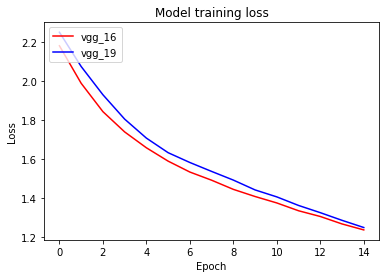

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

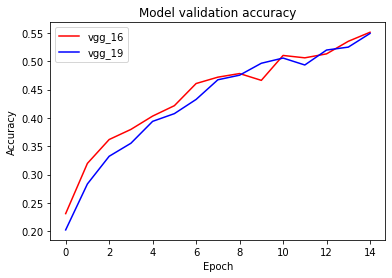

In [16]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

In [17]:
def build_resnet_block(filters=64, is_50=False)

def build_resnet(input_shape, is_50=False):
    # input layer
    input_layer = keras.layers.Input(shape=input_shape)
    
    # Conv1
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
        
    # Conv2
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    output = x
    return keras.Model(
        inputs=input_layer, 
        outputs=output
    )

resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

SyntaxError: invalid syntax (1015899269.py, line 1)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np 

def resnet_block(input_layer, filters, strides=1, is_50=False, is_plain=False):
    first_kernel_size = 3
    first_padding = 'same'
    last_filters = filters    
    if is_50:
        first_kernel_size = 1
        first_padding = 'valid'
        last_filters = filters * 4
    
    x = layers.Conv2D(filters, kernel_size=first_kernel_size, strides=strides, padding=first_padding)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    if is_50:
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(last_filters, kernel_size=1, strides=1, padding='valid')(x)
        x = layers.BatchNormalization()(x)
    
    if is_plain==False:
        # 잔차 연결
        shortcut = input_layer
        if strides > 1 or is_50:
            shortcut = layers.Conv2D(last_filters, kernel_size=1, strides=strides, padding=first_padding)(shortcut)
            if strides > 1:
                shortcut = layers.BatchNormalization()(shortcut)    
        x = layers.Add()([x, shortcut])
        
    x = layers.Activation('relu')(x)
    return x

def build_resnet(input_shape, num_classes, is_50=False, is_plain=False):
    # input layer
    input_layer = layers.Input(shape=input_shape)
    
    x = input_layer
        
    # Conv1
    x = layers.Conv2D(64, 7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
        
    # Conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)
    for i in range(3):
        x = resnet_block(x, 64, 1, is_50, is_plain)
    
    # Conv3
    for i in range(4):
        s = 1
        if i==0:
            s = 2
        x = resnet_block(x, 128, s, is_50, is_plain)
    
    # Conv4
    for i in range(6):
        s = 1
        if i==0:
            s = 2
        x = resnet_block(x, 256, s, is_50, is_plain)
        
    # Conv5
    for i in range(3):
        s = 1
        if i==0:
            s = 2
        x = resnet_block(x, 512, s, is_50, is_plain)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return Model(
        inputs=input_layer, 
        outputs=outputs
    )

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ImportError: cannot import name 'cats_vs_dogs' from 'tensorflow.keras.datasets' (/opt/conda/lib/python3.9/site-packages/keras/api/_v2/keras/datasets/__init__.py)